In [1]:
'''
Deep Learning Brasil (www.deeplearningbrasil.com.br e https://github.com/deeplearningbrasil)
Exemplo de aproximacao de funcao usando GAN - Generative Adversarial Networks - TensorFlow.

Baseado no artigo original de Ian Goodfellow et. al.: https://arxiv.org/abs/1406.2661 e nos posts de Eric Jang: http://blog.evjang.com/2016/06/generative-adversarial-nets-in.html e Arthur Juliani https://medium.com/@awjuliani/generative-adversarial-networks-explained-with-a-classic-spongebob-squarepants-episode-54deab2fce39#.3gu2q43ah

A tecnica de discriminante em minibatch foi obtida de Tim Salimans et. al.: https://arxiv.org/abs/1606.03498.
'''
from __future__ import absolute_import
from __future__ import print_function
from __future__ import unicode_literals
from __future__ import division

import argparse
import numpy as np
from scipy.stats import norm
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns

sns.set(color_codes=True)

seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

In [2]:
class DistribuicaoDados(object):
    def __init__(self):
        self.media = 4
        self.desvio_padrao = 0.5

    def sample(self, N):
        amostras = np.random.normal(self.media, self.desvio_padrao, N)
        amostras.sort()
        return amostras

In [3]:
class DistribuicaoDadosGerador(object):
    def __init__(self, range):
        self.range = range

    def sample(self, N):
        return np.linspace(-self.range, self.range, N) + \
            np.random.random(N) * 0.01

In [4]:
def linear(input, output_dim, scope=None, stddev=1.0):
    norm = tf.random_normal_initializer(stddev=stddev)
    const = tf.constant_initializer(0.0)
    with tf.variable_scope(scope or 'linear'):
        w = tf.get_variable('w', [input.get_shape()[1], output_dim], initializer=norm)
        b = tf.get_variable('b', [output_dim], initializer=const)
        return tf.matmul(input, w) + b

In [5]:
def linear(input, output_dim, scope=None, stddev=1.0):
    norm = tf.random_normal_initializer(stddev=stddev)
    const = tf.constant_initializer(0.0)
    with tf.variable_scope(scope or 'linear'):
        w = tf.get_variable('w', [input.get_shape()[1], output_dim], initializer=norm)
        b = tf.get_variable('b', [output_dim], initializer=const)
        return tf.matmul(input, w) + b

In [6]:
def gerador(input, hidden_size):
    passo1 = linear(input,hidden_size,'g0')
    passo2 = tf.nn.softplus(passo1)
    passo3 = linear(passo2, 1, 'g1')
    return passo3 

In [7]:
def discriminador(input, h_dim, minibatch_layer=True):
    passo1_h0 = linear(input,h_dim*2,'d0')
    passo2_h0 = tf.tanh(passo1_h0)
    passo1_h1 = linear(passo2_h0,h_dim*2,'d1')
    passo2_h1 = tf.tanh(passo1_h1)

    #Sem a camada de minibatch, o discriminador precisa de uma camada adicional 
    #para ter capacidade de separar as duas distribuicoes
    if minibatch_layer:
        passo3_h2 = minibatch(passo2_h1)
    else:
        passo3_h2 = tf.tanh(linear(passo2_h1, h_dim * 2, scope='d2'))

    h3 = tf.sigmoid(linear(passo3_h2, 1, scope='d3'))
    return h3

In [8]:
def minibatch(input, num_kernels=5, kernel_dim=3):
    x = linear(input, num_kernels * kernel_dim, scope='minibatch', stddev=0.02)
    activation = tf.reshape(x, (-1, num_kernels, kernel_dim))
    diffs = tf.expand_dims(activation, 3) - tf.expand_dims(tf.transpose(activation, [1, 2, 0]), 0)
    abs_diffs = tf.reduce_sum(tf.abs(diffs), 2)
    minibatch_features = tf.reduce_sum(tf.exp(-abs_diffs), 2)
    #tensorflow < 1
    #return tf.concat(1, [input, minibatch_features])
    #tensorflow 1
    return tf.concat(axis=1, values=[input, minibatch_features])

In [9]:
def otimizador(erro, var_list, taxa_aprendizado_inicial):
    decaimento = 0.95
    qtd_passos_decaimento = 150
    batch = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        taxa_aprendizado_inicial,
        batch,
        qtd_passos_decaimento,
        decaimento,
        staircase=True
    )
    otimizador = tf.train.GradientDescentOptimizer(learning_rate).minimize(
        erro,
        global_step=batch,
        var_list=var_list
    )
    return otimizador

In [10]:
class GAN(object):
    def __init__(self, data, gen, num_steps, batch_size, minibatch, log_every, anim_path=None):
        self.data = data
        self.gen = gen
        self.num_steps = num_steps
        self.batch_size = batch_size
        self.minibatch = minibatch
        self.log_every = log_every
        self.mlp_hidden_size = 4
        self.anim_path = anim_path
        self.anim_frames = []

        # se nao usar minibatch, usa-se uma taxa de aprendizem mais alta
        if self.minibatch:
            self.learning_rate = 0.005
        else:
            self.learning_rate = 0.03

        self._create_model()

    def _create_model(self):
        #  Cria a rede pre-treinada D_pre utilizando maximum likehood. A rede e 
        # utilizada para repassar informacao do gradiente para a rede geradora 
        # no primeiro passo.
        with tf.variable_scope('D_pre'):
            self.pre_input = tf.placeholder(tf.float32, shape=(self.batch_size, 1))
            self.pre_labels = tf.placeholder(tf.float32, shape=(self.batch_size, 1))
            D_pre = discriminador(self.pre_input, self.mlp_hidden_size, self.minibatch)
            self.pre_loss = tf.reduce_mean(tf.square(D_pre - self.pre_labels))
            self.pre_opt = otimizador(self.pre_loss, None, self.learning_rate)

        # Define a rede geradora - esta obtem dados de entrada a partir de uma 
        # distribuicao com ruidos, e repassa para uma rede MLP.
        with tf.variable_scope('Gen'):
            self.z = tf.placeholder(tf.float32, shape=(self.batch_size, 1))
            self.G = gerador(self.z, self.mlp_hidden_size)

        # O discriminador tentara diferenciar as amostras reais (self.x) 
        # das sinteticas (self.z)
        with tf.variable_scope('Disc') as scope:
            self.x = tf.placeholder(tf.float32, shape=(self.batch_size, 1))
            self.D1 = discriminador(self.x, self.mlp_hidden_size, self.minibatch)
            scope.reuse_variables()
            #cria uma segunda rede de discriminacao, pois no tensorflow nao seria 
            #possivel uma rede com duas entradas diferentes
            self.D2 = discriminador(self.G, self.mlp_hidden_size, self.minibatch)

        # Define a funcao de erro, para a rede de discriminacao e de geracao
        self.loss_d = tf.reduce_mean(-tf.log(self.D1) - tf.log(1 - self.D2))
        self.loss_g = tf.reduce_mean(-tf.log(self.D2))

        self.d_pre_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='D_pre')
        self.d_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Disc')
        self.g_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Gen')

        #define o otimizador para ambas as redes
        self.opt_d = otimizador(self.loss_d, self.d_params, self.learning_rate)
        self.opt_g = otimizador(self.loss_g, self.g_params, self.learning_rate)

    def train(self):
        with tf.Session() as session:
            tf.global_variables_initializer().run()
            log_loss_d = []
            log_loss_g = []
            # discriminador pre-treinado
            num_pretrain_steps = 1000
            for step in range(num_pretrain_steps):
                d = (np.random.random(self.batch_size) - 0.5) * 10.0
                labels = norm.pdf(d, loc=self.data.media, scale=self.data.desvio_padrao)
                pretrain_loss, _ = session.run([self.pre_loss, self.pre_opt], {
                    self.pre_input: np.reshape(d, (self.batch_size, 1)),
                    self.pre_labels: np.reshape(labels, (self.batch_size, 1))
                })
            self.weightsD = session.run(self.d_pre_params)

            # copia os pesos da rede a partir da rede pre-treinada para a rede discriminativa D
            for i, v in enumerate(self.d_params):
                session.run(v.assign(self.weightsD[i]))

            for step in range(self.num_steps):
                # atualiza o discriminador
                x = self.data.sample(self.batch_size)
                z = self.gen.sample(self.batch_size)
                loss_d, _ = session.run([self.loss_d, self.opt_d], {
                    self.x: np.reshape(x, (self.batch_size, 1)),
                    self.z: np.reshape(z, (self.batch_size, 1))
                })

                # atualiza o gerador
                z = self.gen.sample(self.batch_size)
                loss_g, _ = session.run([self.loss_g, self.opt_g], {
                    self.z: np.reshape(z, (self.batch_size, 1))
                })

                if step % self.log_every == 0:
                    print('{}: {}\t{}'.format(step, loss_d, loss_g))
                    log_loss_d.append(loss_d)
                    log_loss_g.append(loss_g)
                    self.anim_frames.append(self._samples(session))


                if self.anim_path:
                    self.anim_frames.append(self._samples(session))

            if self.anim_path:
                self._save_animation()
            else:
                #self._save_animation()
                self._plot_distributions(session)
            #Plota os logs de perdas das redes   
            plt.plot(log_loss_d, label='Rede discriminante')
            plt.plot(log_loss_g, label='Rede geradora')            
            plt.xlabel('Epoca')
            plt.ylabel('Perda')    
            plt.legend()
            plt.show()    

    #nao estamos usando esta funcao nesta versao
    def _samples(self, session):
        '''
        Retorna uma tupla (db,pd,pg), em que db e a fronteira de decisao atual, 
        pd o histograma de amostras a partir da distribuicao de dados,
        e pg o histograma de amostras que foram geradas.
        '''
        num_points=10000 
        num_bins=100
        xs = np.linspace(-self.gen.range, self.gen.range, num_points)
        bins = np.linspace(-self.gen.range, self.gen.range, num_bins)

        # fronteira de decisao
        db = np.zeros((num_points, 1))
        for i in range(num_points // self.batch_size):
            db[self.batch_size * i:self.batch_size * (i + 1)] = session.run(self.D1, {
                self.x: np.reshape(
                    xs[self.batch_size * i:self.batch_size * (i + 1)],
                    (self.batch_size, 1)
                )
            })

        # distribuicao dos dados
        d = self.data.sample(num_points)
        pd, _ = np.histogram(d, bins=bins, density=True)

        # amostras geradas
        zs = np.linspace(-self.gen.range, self.gen.range, num_points)
        g = np.zeros((num_points, 1))
        for i in range(num_points // self.batch_size):
            g[self.batch_size * i:self.batch_size * (i + 1)] = session.run(self.G, {
                self.z: np.reshape(
                    zs[self.batch_size * i:self.batch_size * (i + 1)],
                    (self.batch_size, 1)
                )
            })
        pg, _ = np.histogram(g, bins=bins, density=True)

        return db, pd, pg

    def _plot_distributions(self, session):
        db, pd, pg = self._samples(session)
        db_x = np.linspace(-self.gen.range, self.gen.range, len(db))
        p_x = np.linspace(-self.gen.range, self.gen.range, len(pd))
        f, ax = plt.subplots(1)
        ax.plot(db_x, db, label='Fronteira discriminante')
        ax.set_ylim(0, 1)
        plt.plot(p_x, pd, label='dados reais')
        plt.plot(p_x, pg, label='dados sinteticos')
        plt.title('GAN - Deep Learning Brasil')
        plt.xlabel('Valores')
        plt.ylabel('Densidade de probabilidade')
        plt.legend()
        plt.show()
        return db,pd,pg
        
    def _save_animation(self):
        f, ax = plt.subplots(figsize=(6, 4))
        f.suptitle('deeplearningbrasil.com.br - GAN Network', fontsize=15)
        plt.xlabel('Valores')
        plt.ylabel('Densidade de probabilidade')
        ax.set_xlim(-6, 6)
        ax.set_ylim(0, 1.4)
        line_db, = ax.plot([], [], label='Fronteira discriminante')
        line_pd, = ax.plot([], [], label='Dados reais')
        line_pg, = ax.plot([], [], label='Dados sinteticos')
        frame_number = ax.text(
            0.02,
            0.95,
            '',
            horizontalalignment='left',
            verticalalignment='top',
            transform=ax.transAxes
        )
        ax.legend()

        db, pd, _ = self.anim_frames[0]
        db_x = np.linspace(-self.gen.range, self.gen.range, len(db))
        p_x = np.linspace(-self.gen.range, self.gen.range, len(pd))

        def init():
            line_db.set_data([], [])
            line_pd.set_data([], [])
            line_pg.set_data([], [])
            frame_number.set_text('')
            return (line_db, line_pd, line_pg, frame_number)

        def animate(i):
            frame_number.set_text(
                'Frame: {}/{}'.format(i, len(self.anim_frames))
            )
            db, pd, pg = self.anim_frames[i]
            line_db.set_data(db_x, db)
            line_pd.set_data(p_x, pd)
            line_pg.set_data(p_x, pg)
            return (line_db, line_pd, line_pg, frame_number)

        anim = animation.FuncAnimation(
            f,
            animate,
            init_func=init,
            frames=len(self.anim_frames),
            blit=True
        )
        # grava o video da sequencia de figuras (opcional)
        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
        anim.save(self.anim_path, writer=writer)
        #anim.save(self.anim_path, fps=30, extra_args=['-vcodec', 'libx264'])

In [11]:
def main(args):
    model = GAN(
        DistribuicaoDados(),
        DistribuicaoDadosGerador(range=8),
        args.num_steps,
        args.batch_size,
        args.minibatch,
        args.log_every,
        args.anim
    )
    model.train()

In [12]:
model = GAN(DistribuicaoDados(),DistribuicaoDadosGerador(range=8),1200,12,False,10)

0: 0.7380585670471191	3.5914671421051025
10: 0.07517904043197632	3.8571207523345947
20: 0.058530379086732864	4.033097743988037
30: 0.047292549163103104	4.186099052429199
40: 0.038855936378240585	4.329392910003662
50: 0.03230081871151924	4.471872806549072
60: 0.026882939040660858	4.619630813598633
70: 0.02166651003062725	4.778751850128174
80: 0.017962055280804634	4.95982551574707
90: 0.014955970458686352	5.183943748474121
100: 0.01305995974689722	5.401859283447266
110: 0.01208085473626852	5.502466678619385
120: 0.011384042911231518	5.547361850738525
130: 0.0110103078186512	5.580081939697266
140: 0.010655629448592663	5.60866117477417
150: 0.010258215479552746	5.6353759765625
160: 0.00990926381200552	5.659661769866943
170: 0.009597093798220158	5.682948589324951
180: 0.009431968443095684	5.7054314613342285
190: 0.009204029105603695	5.7271294593811035
200: 0.00891509372740984	5.748252868652344
210: 0.008653764612972736	5.76861047744751
220: 0.00839835312217474	5.7884297370910645
230: 0.0082

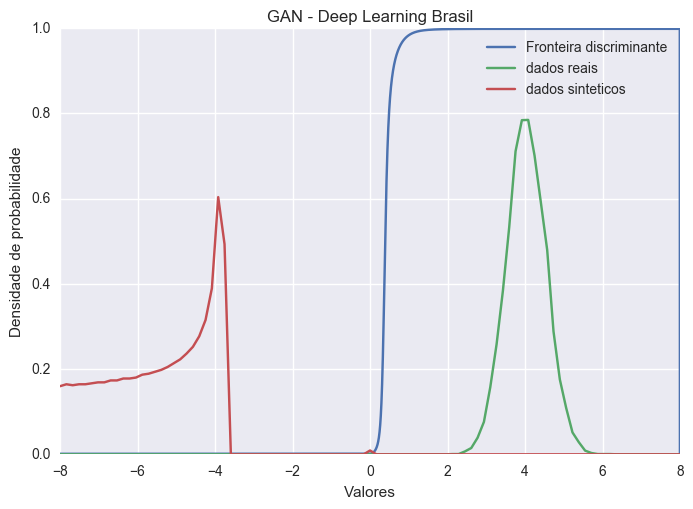

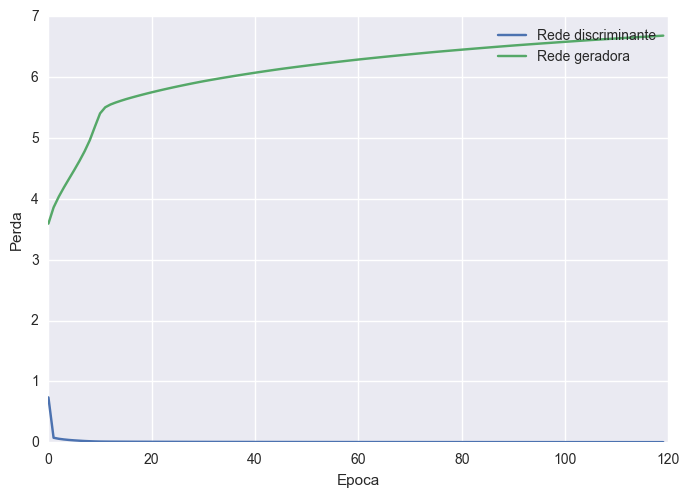

In [13]:
model.train()